# Set up environment
Let's load the basic modules and read the tables from disk

In [1]:
import numpy as np
import astropy.units as u
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

We will now load the two tables we generated in the last session. `data1` contains the Gaia query in a rectangle around our region of interest, excluding negative parallaxes. `cluster1` is our selection on the previous table to select sources with parallaxes between 5.0 and 5.7 mas.

⚠️ If you want to use the "official" `data1` and `cluster1` tables instead of the ones created by yourself do:
- open a terminal
- Navigate to the data folder  
`cd pysnacks_1/tutorials/data`
- Delete the files `data1.ecsv` and `cluster1.ecsv`.

In [2]:
import os
for my_file in ['data1', 'cluster1']:
    if not os.path.isfile(f'../data/{my_file}.ecsv'):
        print(f'Using official {my_file} file')
        os.system(f'unzip ../data/backup/{my_file}.ecsv.zip')
        os.system(f'mv {my_file}.ecsv ../data')
    else:
        print(f'Doing nothing because ../data/{my_file}.ecsv already exists')

Doing nothing because ../data/data1.ecsv already exists
Doing nothing because ../data/cluster1.ecsv already exists


In [3]:
data1 = Table.read('../data/data1.ecsv')
cluster1 = Table.read('../data/cluster1.ecsv')

# ADQL searches

Astronomical Data Query Language (ADQL) is a language developed for astronomy to query catalogs and tables following Virtual Observatory standards. Full specifications can be found [here](https://www.ivoa.net/documents/ADQL/20180112/PR-ADQL-2.1-20180112.html).

- Other resources are this [ADQL Cheat Sheet](http://simbad.u-strasbg.fr/simbad/tap/help/adqlHelp.html)
- Many ADQL examples on Gaia data: https://gaia.ari.uni-heidelberg.de/tap.html

In [4]:
from astroquery.gaia import Gaia

Gaia provides a large amount of tables. If you want to see all available tables (including many cross-matches with other catalogs like SDSS, WISE, UCAC4, Hipparcos, etc) you can run:
```python
tables = Gaia.load_tables(only_names=True)
for table in tables:
    print(table.name)
```

For this tutorial we are going to use table the full Gaia EDR3 catalog: `gaiaedr3.gaia_source`.

## Basic ADQL query

There are 4 main stages for a query:
1. Write the query as a text string
2. Launch the job with the function `Gaia.launch_job()`
3. Convert the job into an astropy Table with `job.get_results()`.

The query will be written as a python string, which will then be send to a job to actually conduct the query on the Gaia server. The main ingredients to write a query are these statements.
- `SELECT`: this statement is used to select data from a database.
- `TOP`: to limit the query to a certain number of rows. `*` would download all the rows, be careful!
- `FROM`: to indicate the table we want to query.
- `WHERE`: to include a filter to select specific data. `AND` to include additional filters.

Although it is not a formal requirement, these statements are usually included in CAPITAL letters, while our values are written in lowercase.

In [5]:
query1 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax
FROM
    gaiaedr3.gaia_source
"""

Note that dividing in lines and adding spaces is just to make it nice. The query could be written as:
```python
query1 = "SELECT TOP 10 ra, dec, pmra, pmdec, parallax FROM gaiaedr3.gaia_source"
```

In [6]:
job1 = Gaia.launch_job(query1)   # Here is where the data are downloaded!

In [7]:
table1 = job1.get_results()

In [8]:
table1

ra,dec,pmra,pmdec,parallax
deg,deg,mas / yr,mas / yr,mas
float64,float64,float64,float64,float64
276.8272363249419,-23.36668286912214,-1.371898184879889,-3.186157566832506,0.5283438664979859
276.8232169716289,-23.369388814928357,--,--,--
276.82806075487196,-23.363751699409708,-1.7157338177912043,-4.769110065387002,0.6551034285648674
276.842096307241,-23.369000319223897,2.6251380887898645,0.3281248125702702,0.09840819001519581
276.83391452535005,-23.365123305276086,--,--,--
276.82597480165475,-23.368778891495012,--,--,--
276.84262877586053,-23.36986985273777,--,--,--
276.84017361437816,-23.37072024770279,--,--,--


Now let's add a filter. This will be filtered in the input catalog, so it is fast

In [9]:
query2 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax
FROM
    gaiaedr3.gaia_source
WHERE
    parallax > 250
"""
job2 = Gaia.launch_job(query2)
table2 = job2.get_results()
table2

ra,dec,pmra,pmdec,parallax
deg,deg,mas / yr,mas / yr,mas
float64,float64,float64,float64,float64
319.2950181380955,-38.872456400701786,-3258.966218702396,-1145.8623969124255,251.9124222107058
77.9599373502188,-45.0438126993602,6491.223339061598,-5708.614150045243,254.19859326384577
43.26964247679057,16.86437381897744,3429.0828268077694,-3805.54112273733,260.98844068047276
111.85462844259372,5.209382701706996,571.2323467293181,-3691.4865653792745,264.12689775460655
18.13325425370941,-16.996154872479234,1205.074450317742,637.5466339679103,269.05730465038937
331.07645259656397,-56.79381206688221,3981.97666296105,-2466.8318147663504,270.6580324694526
54.00339387736301,-44.51436231604776,745.6543400042402,-373.3232809136534,272.16154083178225
26.009055057160104,-15.933680200693857,-1721.7277944720731,854.9631570589582,273.80974511859966


And adding additional filters is also easy:


In [10]:
query3 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source
WHERE
    parallax > 10
    AND dec BETWEEN 55 AND 60
    AND pmra > 100
"""
job3 = Gaia.launch_job(query3)
table3 = job3.get_results()
table3

ra,dec,pmra,pmdec,parallax,phot_g_mean_mag
deg,deg,mas / yr,mas / yr,mas,mag
float64,float64,float64,float64,float64,float32
39.55534450841904,55.70117410383229,133.8178117295073,-11.837413755695902,19.11510100168238,11.550609
73.001541835844,57.82064962211621,174.67043502513522,-173.62505448473277,16.17298230381911,16.471771
67.93424053887837,56.49415175469436,156.26681909748066,-203.33919856668535,15.3333870648532,17.843945
70.52203182388584,57.218527577845585,121.71501407431862,-17.931875936951727,13.118525159179592,14.149204
67.77970024894226,57.14174772278866,117.29933997974308,-10.000585324838873,30.862572147591337,9.700968
67.56932178379238,57.403814933033615,122.11089841693095,-98.56116554188154,11.743476351018504,11.513459
68.21080482528,56.52847940299108,349.04936080414313,-299.0663710676119,29.272908092568912,15.477264
69.03014271319383,55.410901812317256,543.9124159491503,-302.82400193311247,30.09392297788444,8.076589


### ⛏ Exercise 3.1
Construct and run a query named `job3_1` using the following information:
- Select 10 rows.
- Query table `gaiaedr3.gaia_source`.
- Select columns: right ascension, declination and phot_g_mean_mag.
- Use filters to select stars with dec between 50 and 80 deg and magnitude brighter than 10

In [11]:
query3_1 = """
SELECT
TOP 10
    ra, dec, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source
WHERE
    dec BETWEEN 50 AND 80
    AND phot_g_mean_mag < 10
"""
job3_1 = Gaia.launch_job(query3_1)
table3_1 = job3_1.get_results()
table3_1

ra,dec,phot_g_mean_mag
deg,deg,mag
float64,float64,float32
193.50817846782095,55.959784778923755,1.731607
10.12724197930297,56.53718879378639,1.9425238
14.177450998208093,60.71672280471204,2.0645833
2.2990654282325518,59.14897576410493,2.232691
200.98237336533253,54.92525907860076,2.282647
165.46097417209683,56.38257749355825,2.3985364
319.64633694354825,62.58579604829105,2.428267
178.45836676657404,53.694797326318046,2.4362755


How to know which columns are available?

In [12]:
table_metadata = Gaia.load_table('gaiaedr3.gaia_source')
for column in table_metadata.columns:
    print(f"{column.name:30}: {column.description}")

Retrieving table 'gaiaedr3.gaia_source'
solution_id                   : Solution Identifier
designation                   : Unique source designation (unique across all Data Releases)
source_id                     : Unique source identifier (unique within a particular Data Release)
random_index                  : Random index used to select subsets
ref_epoch                     : Reference epoch
ra                            : Right ascension
ra_error                      : Standard error of right ascension
dec                           : Declination
dec_error                     : Standard error of declination
parallax                      : Parallax
parallax_error                : Standard error of parallax
parallax_over_error           : Parallax divided by its standard error
pm                            : Total proper motion
pmra                          : Proper motion in right ascension direction
pmra_error                    : Standard error of proper motion in right ascension 

We can rename columns and give a name to the table.

In [13]:
query4 = """
SELECT
TOP 10
    ra AS right_ascension, dec AS declination, pmra, pmdec, parallax AS plx, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 10
    AND dec > 60
    AND pmra > 100
"""
job4 = Gaia.launch_job(query4)
table4 = job4.get_results()
table4

right_ascension,declination,pmra,pmdec,plx,phot_g_mean_mag
deg,deg,mas / yr,mas / yr,mas,mag
float64,float64,float64,float64,float64,float32
124.01144966021175,65.88461692187626,169.84974708266532,-24.570410918912756,18.038639548679384,20.91073
120.43804827470753,68.86202269142112,133.63583347344328,3.3750313610693956,13.72848737126279,16.861578
129.4503472979296,64.71585025054333,120.78641610564706,34.47326771205426,11.339471660941864,9.413093
119.20575805974968,66.83225418999076,161.93030391025002,-212.18945951987138,23.49525243858702,17.78913
118.08689347243653,69.42490496669896,127.26088845038271,-184.6974457158127,14.080704792233242,16.69432
118.08533569980663,69.42563479208752,126.22933243851233,-184.62388991566053,14.056114013587498,14.970832
122.58738707958943,69.72560126912373,162.99237948955613,116.76920053112454,33.463540006349675,6.4029765
127.48968033210458,61.72258164768267,530.7950990781364,-715.2782846089408,49.288752987563555,9.659495


We can create new columns as combinations of other ones including complex operations.


In [14]:
query5 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, pmra_error, pmdec_error,
    sqrt(power(pmra_error, 2) + power(pmdec_error, 2)) AS pm_error
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 10
    AND dec > 60
    AND pmra > 100
    AND sqrt(power(pmra_error, 2) + power(pmdec_error, 2)) < 0.1
"""
job5 = Gaia.launch_job(query5)
table5 = job5.get_results()
table5

ra,dec,pmra,pmdec,pmra_error,pmdec_error,pm_error
deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,
float64,float64,float64,float64,float32,float32,float64
120.43804827470753,68.86202269142112,133.63583347344328,3.3750313610693956,0.041086283,0.055974327,0.06943491846720999
129.4503472979296,64.71585025054333,120.78641610564706,34.47326771205426,0.025411397,0.038386714,0.04603562640305742
118.08689347243653,69.42490496669896,127.26088845038271,-184.6974457158127,0.0427494,0.05347884,0.06846530295085035
118.08533569980663,69.42563479208752,126.22933243851233,-184.62388991566053,0.016621985,0.021808855,0.02742109656416782
127.48968033210458,61.72258164768267,530.7950990781364,-715.2782846089408,0.013492958,0.013408528,0.01902231643441946
126.49040353037444,66.16833582259768,144.786785712217,124.37529053547584,0.030179866,0.04561104,0.05469178322140326
124.59358012860116,61.46085607940323,128.26588482263713,30.42697419536343,0.017638555,0.018331049,0.025439063919976128
107.0934699216425,60.894279372999705,374.403109862856,-347.5239300167945,0.021102061,0.019266477,0.028574361405612567


This means we can directly compute the distance in kpc as 1/parallax[mas]. Note: you cannot call the column "distance" because that is a reserved ADQL statement.

In [15]:
query6 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, 1/parallax AS distance_kpc
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 1
    AND dec > 60
    AND pmra > 100
"""
job6 = Gaia.launch_job(query6)
table6 = job6.get_results()
table6

ra,dec,pmra,pmdec,parallax,distance_kpc
deg,deg,mas / yr,mas / yr,mas,
float64,float64,float64,float64,float64,float64
74.66451270361384,62.15181340608831,100.00193154067665,-88.86589952933775,12.505373845741055,0.07996562216655116
149.41600324144636,67.49217956894574,100.00879826225145,-69.8566220872247,10.091146997935779,0.09909676275695495
139.97476242532935,66.05549888164397,100.0095895872081,-69.62102585379789,15.98423787439987,0.06256163151835883
323.84691274648014,67.52300451606419,100.02507110926138,-6.417828960232144,19.497322234874673,0.051289094366574584
8.774216010678863,66.09847004748724,100.02592661671935,77.55322853028491,4.880189684813282,0.20491006796557754
50.912557004283634,73.96366867624116,100.0261031618998,-94.51463946438408,5.764660649771974,0.17347074888780414
21.723091909676675,69.29224228578344,100.04218136198642,-30.740662923862253,4.436027695340312,0.2254269063852823
6.876645499764789,71.20594200585153,100.04921965493844,2.8273362498455668,3.0536148859229333,0.3274807195268689


For example, we can directly compute the absolute magnitude and create a new column:

In [16]:
query7 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, phot_g_mean_mag,
    gaia.phot_g_mean_mag + 5*log10(gaia.parallax) - 10 AS g_mag_abs
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 10
    AND dec > 60
    AND pmra > 100
"""
job7 = Gaia.launch_job(query7)
table7 = job7.get_results()
table7

ra,dec,pmra,pmdec,parallax,phot_g_mean_mag,g_mag_abs
deg,deg,mas / yr,mas / yr,mas,mag,
float64,float64,float64,float64,float64,float32,float64
124.01144966021175,65.88461692187626,169.84974708266532,-24.570410918912756,18.038639548679384,20.91073,17.19174926444787
120.43804827470753,68.86202269142112,133.63583347344328,3.3750313610693956,13.72848737126279,16.861578,12.54969143040855
129.4503472979296,64.71585025054333,120.78641610564706,34.47326771205426,11.339471660941864,9.413093,4.686056713128586
119.20575805974968,66.83225418999076,161.93030391025002,-212.18945951987138,23.49525243858702,17.78913,14.64402983493899
118.08689347243653,69.42490496669896,127.26088845038271,-184.6974457158127,14.080704792233242,16.69432,12.437442645822813
118.08533569980663,69.42563479208752,126.22933243851233,-184.62388991566053,14.056114013587498,14.970832,10.710158227040015
122.58738707958943,69.72560126912373,162.99237948955613,116.76920053112454,33.463540006349675,6.4029765,4.025835921668726
127.48968033210458,61.72258164768267,530.7950990781364,-715.2782846089408,49.288752987563555,9.659495,8.123234506607584


## Select by region

In [17]:
query8 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    CONTAINS(POINT(ra, dec), CIRCLE(15, 60, 0.1)) = 1
"""
job8 = Gaia.launch_job(query8)
table8 = job8.get_results()
table8

ra,dec,pmra,pmdec,parallax,phot_g_mean_mag
deg,deg,mas / yr,mas / yr,mas,mag
float64,float64,float64,float64,float64,float32
15.071831169789679,59.91302873540859,--,--,--,20.977959
14.933407749253156,59.91153362051373,5.3847781088986935,-1.9325072661079779,-0.30453374880917633,20.50302
14.937958587597747,59.90932563471064,-3.1696274429712084,-1.4072159490972487,0.10879996568743136,18.139885
14.937548388938223,59.90891303230689,-0.7745266496067702,-0.9903480716602326,-0.561817412847953,20.46902
14.939829641766513,59.90624967964418,-2.4632653146799894,-1.2223383927227272,0.1753889214442334,18.504358
14.94113722990093,59.90615950498211,-1.9887068693401864,-1.4055849953931179,-0.3320124881313277,19.67224
14.936752386111156,59.90689111014183,--,--,--,20.935993
14.934914803073248,59.90953548064737,--,--,--,20.938787


## Create a query programatically

In [18]:
my_columns = 'ra, dec, phot_g_mean_mag'
my_table = 'gaiaedr3.gaia_source'
min_dec = 50
max_dec = 80
max_mag = 10

In [19]:
query9 = f"""
SELECT
TOP 10
    {my_columns}
FROM
    {my_table}
WHERE
    dec BETWEEN {min_dec} AND {max_dec}
    AND phot_g_mean_mag < {max_mag}
"""
job9 = Gaia.launch_job(query9)
table9 = job9.get_results()
table9

ra,dec,phot_g_mean_mag
deg,deg,mag
float64,float64,float32
193.50817846782095,55.959784778923755,1.731607
10.12724197930297,56.53718879378639,1.9425238
14.177450998208093,60.71672280471204,2.0645833
2.2990654282325518,59.14897576410493,2.232691
200.98237336533253,54.92525907860076,2.282647
165.46097417209683,56.38257749355825,2.3985364
319.64633694354825,62.58579604829105,2.428267
178.45836676657404,53.694797326318046,2.4362755


You can verify that `query9` is exactly the same as `query3_1` and the `table9` is the same as `table3_1`.

In [20]:
print(query9, query3_1)


SELECT
TOP 10
    ra, dec, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source
WHERE
    dec BETWEEN 50 AND 80
    AND phot_g_mean_mag < 10
 
SELECT
TOP 10
    ra, dec, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source
WHERE
    dec BETWEEN 50 AND 80
    AND phot_g_mean_mag < 10



In [21]:
print(table9)
print(table3_1)

        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
193.50817846782095 55.959784778923755        1.731607
 10.12724197930297  56.53718879378639       1.9425238
14.177450998208093  60.71672280471204       2.0645833
2.2990654282325518  59.14897576410493        2.232691
200.98237336533253  54.92525907860076        2.282647
165.46097417209683  56.38257749355825       2.3985364
319.64633694354825  62.58579604829105        2.428267
178.45836676657404 53.694797326318046       2.4362755
325.87694430713873  58.78002783444686        2.450726
 245.9977069286059 61.514463511632556        2.494415
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
193.50817846782095 55.959784778923755        1.731607
 10.12724197930297  56.53718879378639       1.9425238
14.177450998208093  60.71672

## ⛏ Exercise 3.2

- Use `SkyCoord.from_name()` to get the coordinates of the star Vega.
- Run an ADQL query to find stars within 50 arcsec of that position to obtain columns 'ra, dec, phot_g_mean_mag, distance_kpc'. You will need to compute the new column distance_kpc.
- Is Vega included in the resulting table? Read more [I can not find data for a bright star. Why is that?](https://www.cosmos.esa.int/web/gaia/faqs#BrightStar). Also, read about the VEGAMAG system [here](https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_calibr_extern.html#SSS6):
> The VEGAMAG system is defined so that Vega’s colours are all zero: this is equivalent to normalizing all the observed fluxes to the flux of Vega.

In [22]:
vega_coord = SkyCoord.from_name("Vega")
vega_coord.to_string('hmsdms')
search_radius = 50/60/60 # We need in degrees

In [23]:
query3_2 = f"""
SELECT
TOP 1000
    ra, dec, phot_g_mean_mag, 1/parallax AS distance_kpc
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    CONTAINS(POINT(ra, dec),
    CIRCLE({vega_coord.ra.deg}, {vega_coord.dec.deg}, {search_radius})) = 1
"""
job3_2 = Gaia.launch_job(query3_2)
table3_2 = job3_2.get_results()
table3_2

ra,dec,phot_g_mean_mag,distance_kpc
deg,deg,mag,
float64,float64,float32,float64
279.23090140207887,38.77493571907557,16.828749,1.6757087299450542
279.24601139325796,38.77404619176373,17.17283,-0.5162007040686745
279.24289761454577,38.78910887473515,17.335606,--
279.2222641579334,38.774730984228476,16.93353,0.26777310537663623
279.2242956202031,38.78935247026724,15.78001,1.4851713119866699


### 🌪 Additional fun
Repeat the query around Vega but with a radius of 100 arcsec. Select 50 rows. Make a plot of the R.A. and Dec. of the resulting stars.

Text(0, 0.5, 'Declination [deg]')

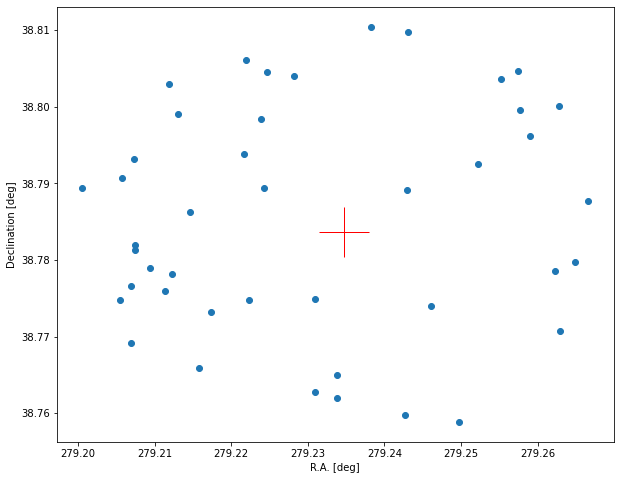

In [24]:
vega_coord = SkyCoord.from_name("Vega")
vega_coord.to_string('hmsdms')
search_radius = 100/60/60 # We need in degrees
query3_2b = f"""
SELECT
TOP 50
    ra, dec, phot_g_mean_mag, 1/parallax AS distance_kpc
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    CONTAINS(POINT(ra, dec),
    CIRCLE({vega_coord.ra.deg}, {vega_coord.dec.deg}, {search_radius})) = 1
"""
job3_2b = Gaia.launch_job(query3_2b)
table3_2b = job3_2b.get_results()
table3_2b

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(table3_2b['ra'], table3_2b['dec'], 'o')
ax.plot(vega_coord.ra.deg, vega_coord.dec.deg, '+', color='r', ms=50)

ax.set_aspect('equal')

ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Declination [deg]')

In [25]:
gaia_columns = ['ra','dec','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_matched_transits','phot_g_mean_flux','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','bp_g','g_rp','dr2_radial_velocity','dr2_radial_velocity_error','dr2_rv_template_teff']
my_columns = ', '.join(gaia_columns)
my_columns

'ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, astrometric_matched_transits, phot_g_mean_flux, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, bp_g, g_rp, dr2_radial_velocity, dr2_radial_velocity_error, dr2_rv_template_teff'

In [26]:
my_table = 'gaiaedr3.gaia_source'
min_ra = 130.025 - 3/2
max_ra = 130.025 + 3/2
min_dec = 19.98333 - 2/2
max_dec = 19.98333 + 2/2
min_parallax = 0

In [27]:
query_final = f"""
SELECT
TOP 35000
    {my_columns},
    1/parallax AS distance_kpc,
    phot_g_mean_mag + 5*log10(parallax) - 10 AS g_mag_abs
FROM
    {my_table}
WHERE
    ra BETWEEN {min_ra} AND {max_ra}
    AND dec BETWEEN {min_dec} AND {max_dec}
    AND parallax > {min_parallax}
"""
job_final = Gaia.launch_job(query_final)
data1_adql = job_final.get_results()

In [28]:
data1_adql

ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_matched_transits,phot_g_mean_flux,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_template_teff,distance_kpc,g_mag_abs
deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,electron / s,mag,mag,mag,mag,mag,mag,km / s,km / s,K,,
float64,float64,float64,float32,float64,float32,float64,float32,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
131.22968270095606,18.983827201863143,0.31998871956721814,0.49794808,-1.6223404085587294,0.5614138,-1.0105924563161917,0.38008142,46,241.0244269476377,19.732214,20.053925,19.384422,0.66950226,0.3217106,0.34779167,--,--,--,3.1251101643598282,7.257887316910093
131.28445136091062,19.00845193710329,0.5151998785794699,1.3006121,-1.5297876468186185,1.2919384,-2.843560646665468,1.2246985,25,96.2696925676696,20.728643,20.89959,20.31875,0.58083916,0.17094612,0.40989304,--,--,--,1.9409942462665961,9.28852217735211
131.28563865066036,19.010494922567894,0.13490804016686328,0.3181554,-3.076730055168175,0.3238071,-7.359471668488383,0.23946682,47,394.8387851857072,19.196318,19.62897,18.777939,0.85103035,0.43265152,0.41837883,--,--,--,7.412456653903898,4.846506839030049
131.25698350902147,18.99538731950092,1.2187092847745848,0.2575996,-5.5986482301070515,0.25462997,-4.4498040876448846,0.19418992,45,575.2274112416579,18.787767,19.775286,17.816483,1.9588032,0.9875183,0.97128487,--,--,--,0.8205402325994112,9.217268009429358
131.2355391791492,18.999266470059794,0.5964944744112647,0.69358546,-9.987451244118489,0.6922935,1.4050607195805065,0.5469776,44,166.8080069396004,20.131824,20.92843,18.943783,1.9846478,0.79660606,1.1880417,--,--,--,1.6764614642692073,9.00985661823622
131.23663846952257,19.000781690200437,0.8711013589326823,0.073754616,-10.281595584933397,0.07906608,1.6545907275451583,0.06229423,45,4077.3282298584913,16.661428,17.27445,15.9210205,1.3534298,0.61302185,0.74040794,--,--,--,1.147972035338403,6.361771907770752
131.27836980626788,19.01688286266123,1.11703994851533,0.01790161,2.057040558069246,0.018296564,1.50343545327416,0.014275822,46,77931.8217543654,13.458079,13.736864,13.01631,0.72055435,0.27878475,0.4417696,--,--,--,0.8952231308549985,3.69842286304986
131.27870091778294,19.020709260033875,4.794118754888754,0.043951128,15.603651580360394,0.045697227,-41.20474724407915,0.034721203,48,9327.298367502075,15.762978,16.970934,14.671906,2.2990274,1.2079563,1.0910711,--,--,--,0.20858890885426234,9.166521538692322


Are the table obtained with ADQL the same obtained with astroquery and modified as a table? Let's see if the number of entries and the averaged values match exacty.

In [29]:
print(len(data1), len(data1_adql))  # The number of entries
print(data1['ra'].mean(),       data1_adql['ra'].mean())           # Same mean R.A.?
print(data1['parallax'].mean(), data1_adql['parallax'].mean())     # Same mean parallax?
print(data1['distance'].mean(), data1_adql['distance_kpc'].mean()) # Same mean computed distance?
print(data1['Mg'].mean(), data1_adql['g_mag_abs'].mean())          # Same mean computed absolute magnitude?
print('Yes!')

23050 23050
129.99954593828224 129.99954593828224
1.2586897281600946 1.2586897281600946
3.644157839486788 3.6441578394867884
7.521207604826898 7.521207604826898
Yes!


In [30]:
#external.gaiaedr3_distance
